In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime 

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func 

# Reflect Tables into SQLAlchemy ORM

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
 # INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first
most_recent_date()

('2017-08-23',)

In [9]:
query = """
    SELECT
        date,
        station,
        prcp
    FROM
       measurement
    Where
        date >= '2016-08-23'
    ORDER BY
        date ASC;
        """
df = pd.read_sql(text(query), con=engine)
df.head(12)
        
    

,date,station,prcp
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02
5,2016-08-23,USC00519281,1.79
6,2016-08-23,USC00516128,0.70
7,2016-08-24,USC00519397,0.08
8,2016-08-24,USC00513117,2.15
9,2016-08-24,USC00514830,2.28


In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
start_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
new_df = pd.DataFrame(results, columns=["Date", "Station", "Precipitation"])

# Sort the dataframe by date
new_df["Date"] = pd.to_datetime(new_df['Date'])
new_df = new_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
new_df.head()

,Date,Station,Precipitation
0,2016-08-23,USC00519397,0.00
1,2016-08-23,USC00513117,0.15
2,2016-08-23,USC00514830,0.05
3,2016-08-23,USC00517948,NaN
4,2016-08-23,USC00519523,0.02


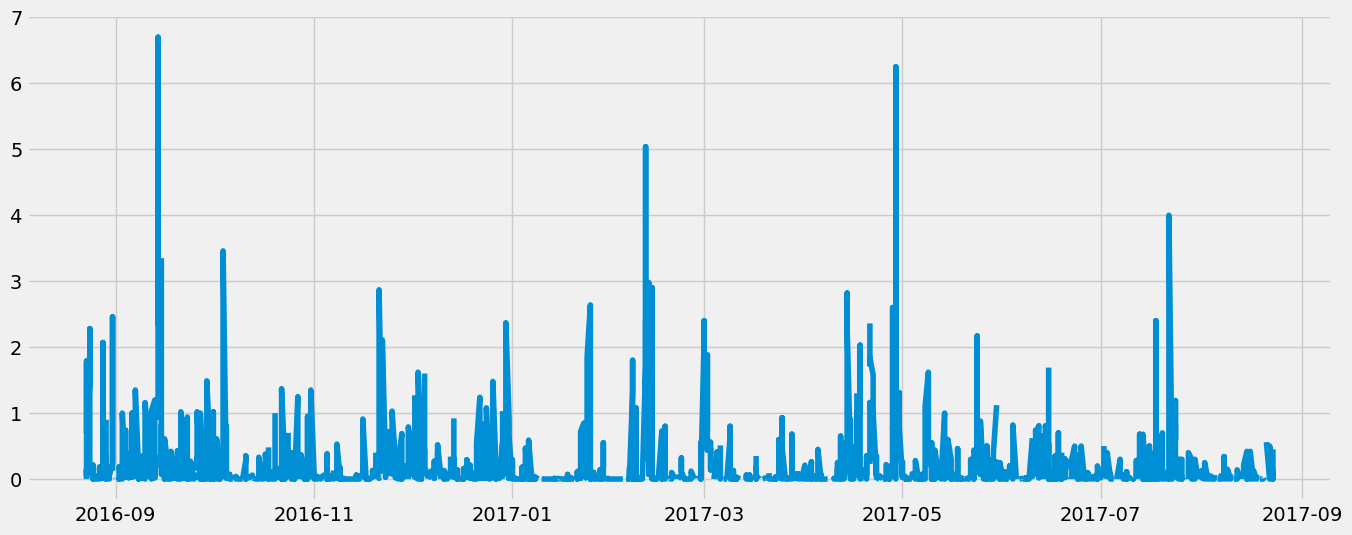

In [16]:
plt.figure(figsize=(15, 6))

plt.plot(new_df.Date, new_df.Precipitation)
plt.show()

In [17]:
new_df.describe()

,Date,Precipitation
count,2230,2021.000000
mean,2017-02-16 05:31:15.874439424,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-18 00:00:00,0.000000
50%,2017-02-14 12:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [74]:
# Design a query to calculate the total number of stations in the dataset
query = "SELECT count(id) from station"

with engine.connect() as conn:
    print(conn.execute(text(query)).fetchall())

[(9,)]


In [79]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = """
    SELECT
        station,
        count(*) as number_rows
    FROM
        measurement
    GROUP BY
        station
    ORDER BY
        number_rows desc;
"""

df = pd.read_sql(text(query), con=engine)
df.head(9)

,station,number_rows
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [81]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
    SELECT
        min(tobs) as min_temp,
        avg(tobs) as avg_temp,
        max(tobs) as max_temp
    FROM
        measurement
    WHERE
        station = 'USC00519281';
"""
df = pd.read_sql(text(query),con=engine)
df.head() 

,min_temp,avg_temp,max_temp
0,54.0,71.663781,85.0


In [87]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = """
    SELECT
        date,
        station,
        tobs
    FROM
        measurement
    WHERE
        date >= '2016-08-23'
        and station = 'USC00519281'
      ORDER BY
        date ASC;
"""

df = pd.read_sql(text(query), con=engine)
df.head()

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


In [88]:
 # Calculate the date one year from the last date in data set.
start_date = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and tobs scores
results = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Date", "Station", "TOBS"])

# Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df2.head()

,Date,Station,TOBS
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


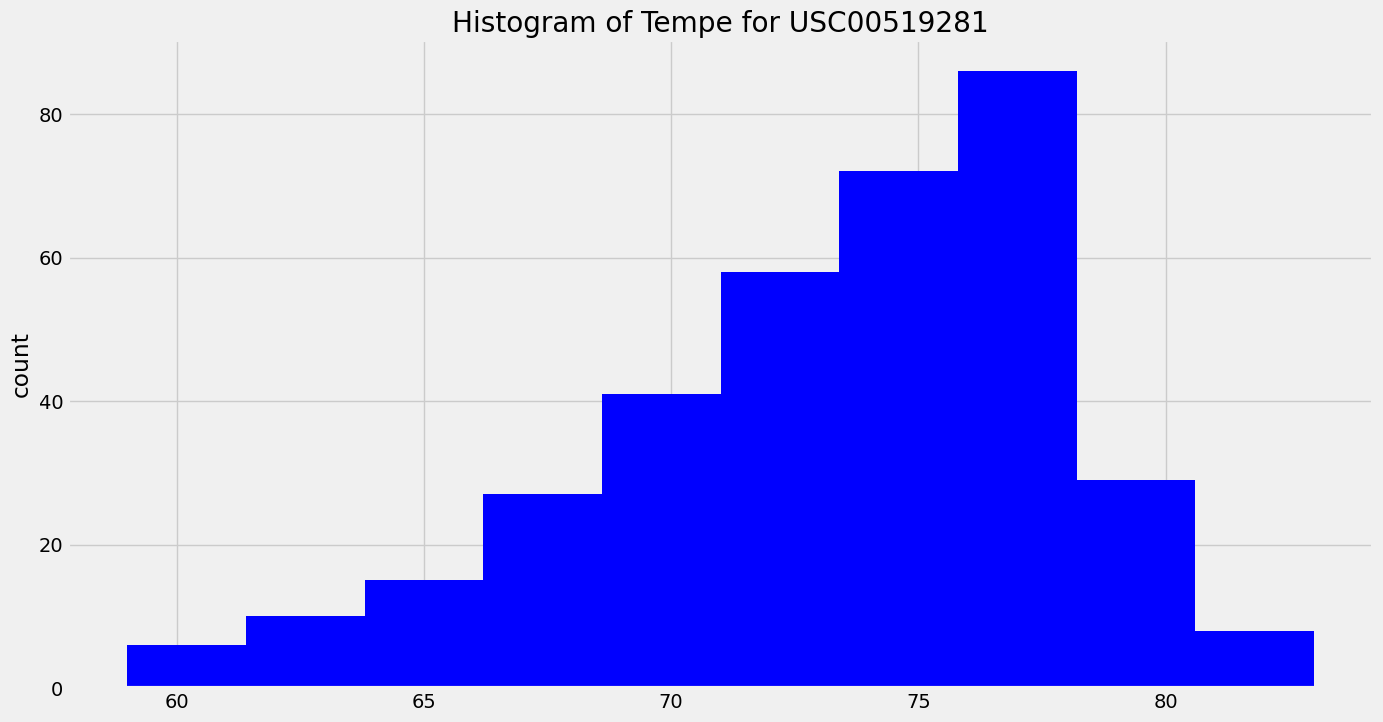

In [90]:
plt.figure(figsize=(15,8))
plt.hist(df2.TOBS, color="blue")
plt.ylabel("count")
plt.title("Histogram of Tempe for USC00519281")
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()